In [42]:
%matplotlib inline


# Cross-Subject SSVEP
This example shows how to perform a cross-subject analysis on an SSVEP dataset.
We will compare four pipelines :

- Riemannian Geometry
- CCA
- TRCA
- MsetCCA

We will use the SSVEP paradigm, which uses the AUC as metric.


In [43]:
# Authors: Sylvain Chevallier <sylvain.chevallier@uvsq.fr>
#
# License: BSD (3-clause)

import warnings

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pyriemann.estimation import Covariances
from pyriemann.tangentspace import TangentSpace
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

import moabb
from moabb.datasets import Kalunga2016
from moabb.evaluations import CrossSubjectEvaluation
from moabb.paradigms import SSVEP, FilterBankSSVEP
from moabb.pipelines import SSVEP_CCA, SSVEP_TRCA, ExtendedSSVEPSignal, SSVEP_MsetCCA


warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=RuntimeWarning)
moabb.set_log_level("info")

## Loading Dataset

We will load the data from the first 2 subjects of the ``SSVEP_Exo`` dataset
and compare two algorithms on this set. One of the algorithms could only
process class associated with a stimulation frequency, we will thus drop
the resting class. As the resting class is the last defined class, picking
the first three classes (out of four) allows to focus only on the stimulation
frequency.



In [44]:
n_subject = 12
dataset = Kalunga2016()
dataset.subject_list = dataset.subject_list[:n_subject]
interval = dataset.interval

## Choose Paradigm

We define the paradigms (SSVEP, SSVEP TRCA, SSVEP MsetCCA, and FilterBankSSVEP) and
use the dataset Kalunga2016. All 3 SSVEP paradigms applied a bandpass filter (10-42 Hz) on
the data, which include all stimuli frequencies and their first harmonics,
while the FilterBankSSVEP paradigm uses as many bandpass filters as
there are stimulation frequencies (here 3). For each stimulation frequency
the EEG is filtered with a 1 Hz-wide bandpass filter centered on the
frequency. This results in ``n_classes`` copies of the signal, filtered for each
class, as used in the filterbank motor imagery paradigms.



In [45]:
paradigm = SSVEP(fmin=10, fmax=42, n_classes=3)
paradigm_TRCA = SSVEP(fmin=10, fmax=42, n_classes=3)
paradigm_MSET_CCA = SSVEP(fmin=10, fmax=42, n_classes=3)
paradigm_fb = FilterBankSSVEP(filters=None, n_classes=3)

2024-07-22 15:23:21,961 WARNING MainThread moabb.paradigms.ssvep Choosing the first 3 classes from all possible events
2024-07-22 15:23:21,962 WARNING MainThread moabb.paradigms.ssvep Choosing the first 3 classes from all possible events
2024-07-22 15:23:21,963 WARNING MainThread moabb.paradigms.ssvep Choosing the first 3 classes from all possible events
2024-07-22 15:23:21,963 WARNING MainThread moabb.paradigms.ssvep Choosing the first 3 classes from all possible events


Classes are defined by the frequency of the stimulation, here we use
the first two frequencies of the dataset, 13 and 17 Hz.
The evaluation function uses a LabelEncoder, transforming them
to 0 and 1



In [46]:
freqs = paradigm.used_events(dataset)

## Create Pipelines

Pipelines must be a dict of sklearn pipeline transformer.
The first pipeline uses Riemannian geometry, by building an extended
covariance matrices from the signal filtered around the considered
frequency and applying a logistic regression in the tangent plane.
The second pipeline relies on the above defined CCA classifier.
The third pipeline relies on the TRCA algorithm,
and the fourth uses the MsetCCA algorithm. Both CCA based methods
(i.e. CCA and MsetCCA) used 3 CCA components.



In [47]:
pipelines_fb = {}
pipelines_fb["RG+LogReg"] = make_pipeline(
    ExtendedSSVEPSignal(),
    Covariances(estimator="lwf"),
    TangentSpace(),
    LogisticRegression(solver="lbfgs", multi_class="auto"),
)

pipelines = {}
pipelines["CCA"] = make_pipeline(SSVEP_CCA(interval=interval, freqs=freqs, n_harmonics=2))

pipelines_TRCA = {}
pipelines_TRCA["TRCA"] = make_pipeline(SSVEP_TRCA(interval=interval, freqs=freqs))

pipelines_MSET_CCA = {}
pipelines_MSET_CCA["MSET_CCA"] = make_pipeline(SSVEP_MsetCCA(freqs=freqs))

## Evaluation

The evaluation will return a DataFrame containing an accuracy score for
each subject / session of the dataset, and for each pipeline.

Results are saved into the database, so that if you add a new pipeline, it
will not run again the evaluation unless a parameter has changed. Results can
be overwritten if necessary.



In [48]:
overwrite =True  # set to True if we want to overwrite cached results

evaluation = CrossSubjectEvaluation(
    paradigm=paradigm, datasets=dataset, overwrite=overwrite
)
results_pipelines = evaluation.process(pipelines)

2024-07-22 15:23:22,061 INFO MainThread moabb.evaluations.base Processing dataset: Kalunga2016


/Users/skpaul/Library/Python/3.9/lib/python/site-packages/moabb/datasets/preprocessing.py:279: UserWarning: warnEpochs <Epochs |  24 events (all good), 2 – 4 s, baseline off, ~785 kB, data loaded,
 '13': 8
 '17': 8
 '21': 8>
  warn(f"warnEpochs {epochs}")
/Users/skpaul/Library/Python/3.9/lib/python/site-packages/moabb/datasets/preprocessing.py:279: UserWarning: warnEpochs <Epochs |  24 events (all good), 2 – 4 s, baseline off, ~785 kB, data loaded,
 '13': 8
 '17': 8
 '21': 8>
  warn(f"warnEpochs {epochs}")
/Users/skpaul/Library/Python/3.9/lib/python/site-packages/moabb/datasets/preprocessing.py:279: UserWarning: warnEpochs <Epochs |  24 events (all good), 2 – 4 s, baseline off, ~785 kB, data loaded,
 '13': 8
 '17': 8
 '21': 8>
  warn(f"warnEpochs {epochs}")
/Users/skpaul/Library/Python/3.9/lib/python/site-packages/moabb/datasets/preprocessing.py:279: UserWarning: warnEpochs <Epochs |  24 events (all good), 2 – 4 s, baseline off, ~785 kB, data loaded,
 '13': 8
 '17': 8
 '21': 8>
  warn(

Filter bank processing, determine the filter automatically from the
stimulation frequency values of events.



In [49]:
evaluation_fb = CrossSubjectEvaluation(
    paradigm=paradigm_fb, datasets=dataset, overwrite=overwrite
)
results_fb = evaluation_fb.process(pipelines_fb)

2024-07-22 15:25:19,780 INFO MainThread moabb.evaluations.base Processing dataset: Kalunga2016
/Users/skpaul/Library/Python/3.9/lib/python/site-packages/moabb/datasets/preprocessing.py:279: UserWarning: warnEpochs <Epochs |  24 events (all good), 2 – 4 s, baseline off, ~785 kB, data loaded,
 '13': 8
 '17': 8
 '21': 8>
  warn(f"warnEpochs {epochs}")
/Users/skpaul/Library/Python/3.9/lib/python/site-packages/moabb/datasets/preprocessing.py:279: UserWarning: warnEpochs <Epochs |  24 events (all good), 2 – 4 s, baseline off, ~785 kB, data loaded,
 '13': 8
 '17': 8
 '21': 8>
  warn(f"warnEpochs {epochs}")
/Users/skpaul/Library/Python/3.9/lib/python/site-packages/moabb/datasets/preprocessing.py:279: UserWarning: warnEpochs <Epochs |  24 events (all good), 2 – 4 s, baseline off, ~785 kB, data loaded,
 '13': 8
 '17': 8
 '21': 8>
  warn(f"warnEpochs {epochs}")
/Users/skpaul/Library/Python/3.9/lib/python/site-packages/moabb/datasets/preprocessing.py:279: UserWarning: warnEpochs <Epochs |  24 even

TRCA processing also relies on filter bank that is automatically designed.



In [50]:
evaluation_TRCA = CrossSubjectEvaluation(
    paradigm=paradigm_TRCA, datasets=dataset, overwrite=overwrite
)
results_TRCA = evaluation_TRCA.process(pipelines_TRCA)

2024-07-22 15:25:35,038 INFO MainThread moabb.evaluations.base Processing dataset: Kalunga2016
/Users/skpaul/Library/Python/3.9/lib/python/site-packages/moabb/datasets/preprocessing.py:279: UserWarning: warnEpochs <Epochs |  24 events (all good), 2 – 4 s, baseline off, ~785 kB, data loaded,
 '13': 8
 '17': 8
 '21': 8>
  warn(f"warnEpochs {epochs}")
/Users/skpaul/Library/Python/3.9/lib/python/site-packages/moabb/datasets/preprocessing.py:279: UserWarning: warnEpochs <Epochs |  24 events (all good), 2 – 4 s, baseline off, ~785 kB, data loaded,
 '13': 8
 '17': 8
 '21': 8>
  warn(f"warnEpochs {epochs}")
/Users/skpaul/Library/Python/3.9/lib/python/site-packages/moabb/datasets/preprocessing.py:279: UserWarning: warnEpochs <Epochs |  24 events (all good), 2 – 4 s, baseline off, ~785 kB, data loaded,
 '13': 8
 '17': 8
 '21': 8>
  warn(f"warnEpochs {epochs}")
/Users/skpaul/Library/Python/3.9/lib/python/site-packages/moabb/datasets/preprocessing.py:279: UserWarning: warnEpochs <Epochs |  24 even

MsetCCA processing



In [51]:
evaluation_MSET_CCA = CrossSubjectEvaluation(
    paradigm=paradigm_MSET_CCA, datasets=dataset, overwrite=overwrite
)
results_MSET_CCA = evaluation_MSET_CCA.process(pipelines_MSET_CCA)

2024-07-22 15:28:29,740 INFO MainThread moabb.evaluations.base Processing dataset: Kalunga2016
/Users/skpaul/Library/Python/3.9/lib/python/site-packages/moabb/datasets/preprocessing.py:279: UserWarning: warnEpochs <Epochs |  24 events (all good), 2 – 4 s, baseline off, ~785 kB, data loaded,
 '13': 8
 '17': 8
 '21': 8>
  warn(f"warnEpochs {epochs}")
/Users/skpaul/Library/Python/3.9/lib/python/site-packages/moabb/datasets/preprocessing.py:279: UserWarning: warnEpochs <Epochs |  24 events (all good), 2 – 4 s, baseline off, ~785 kB, data loaded,
 '13': 8
 '17': 8
 '21': 8>
  warn(f"warnEpochs {epochs}")
/Users/skpaul/Library/Python/3.9/lib/python/site-packages/moabb/datasets/preprocessing.py:279: UserWarning: warnEpochs <Epochs |  24 events (all good), 2 – 4 s, baseline off, ~785 kB, data loaded,
 '13': 8
 '17': 8
 '21': 8>
  warn(f"warnEpochs {epochs}")
/Users/skpaul/Library/Python/3.9/lib/python/site-packages/moabb/datasets/preprocessing.py:279: UserWarning: warnEpochs <Epochs |  24 even

After processing the four, we simply concatenate the results.



In [52]:
results = pd.concat([results_pipelines, results_fb, results_TRCA, results_MSET_CCA])
results

,score,time,samples,subject,session,channels,n_sessions,dataset,pipeline
0,0.250000,0.003290,672.0,1,0,8,1,Kalunga2016,CCA
1,0.354167,0.002128,672.0,2,0,8,1,Kalunga2016,CCA
2,0.333333,0.002035,672.0,3,0,8,1,Kalunga2016,CCA
3,0.333333,0.002080,672.0,4,0,8,1,Kalunga2016,CCA
4,0.395833,0.001970,672.0,5,0,8,1,Kalunga2016,CCA
5,0.375000,0.002144,672.0,6,0,8,1,Kalunga2016,CCA
6,0.361111,0.001815,648.0,7,0,8,1,Kalunga2016,CCA
7,0.312500,0.002182,672.0,8,0,8,1,Kalunga2016,CCA
8,0.354167,0.001834,672.0,9,0,8,1,Kalunga2016,CCA
9,0.343750,0.001854,624.0,10,0,8,1,Kalunga2016,CCA


## Plot Results

Here we display the results as stripplot, with a pointplot for error bar.



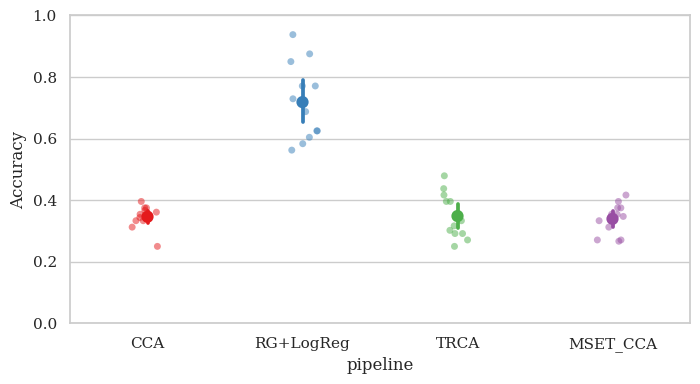

In [54]:
fig, ax = plt.subplots(facecolor="white", figsize=[8, 4])
sns.stripplot(
    data=results,
    y="score",
    x="pipeline",
    ax=ax,
    jitter=True,
    alpha=0.5,
    zorder=1,
    palette="Set1",
)
sns.pointplot(data=results, y="score", x="pipeline", ax=ax, palette="Set1")
ax.set_ylabel("Accuracy")
ax.set_ylim(0.0, 1.0)
plt.show()